In [1]:
# import packages
import h5py
import numpy as np
import torch
from mirtorch.linear import Sense, Diff3dgram
from mirtorch.alg.cg import CG
import os
import sys
from recutl import coil_compress

In [2]:
gpu_idx = 2 # default GPU index for CUDA

# select device
if torch.cuda.is_available():
    print('CUDA is available')
    device0 = torch.device(f'cuda:{gpu_idx}')
else:
    print('CUDA is not available')
    device0 = torch.device('cpu')

CUDA is available


In [3]:
# load in the GRE data
fname = '/home/djfrey/data/lps_fmri_20250331/gre3d.h5' # name of the GRE data file

with h5py.File(fname, 'r') as h5_file:
    kdata = h5_file['kdata/real'][:] + 1j * h5_file['kdata/imag'][:] # kspace data
    msk = h5_file['msk'][:] # sampling mask
    fov = h5_file['seq_args/fov'][0][0] # fov (cm)
    N = int(h5_file['seq_args/N'][0][0]) # 3D matrix size
    Nacs = int(h5_file['seq_args/Nacs'][0][0]) # 3D matrix size
    ncoil = int(h5_file['ncoil'][0][0]) # number of coils

# reshape into tensors
kdata = torch.tensor(kdata).reshape(1,ncoil,N,N,N) # 1 x C x Kz x Ky x Kx
msk = torch.tensor(msk).unsqueeze(0) # 1 x Kz x Ky x Kx

In [4]:
compute_smaps = False # flag to compute the sensitivity maps

if compute_smaps:

    # import BART toolbox
    bart_path = os.getenv('BART_TOOLBOX_PATH')
    if bart_path:
        sys.path.append(os.path.join(bart_path, 'python'))
    else:
        raise EnvironmentError("BART_TOOLBOX_PATH environment variable is not set")
    from bart import bart

    # calculate the coil sensitivity maps
    smaps = bart(1, f'ecalib -b0 -m1 -r{Nacs}', kdata.squeeze(0).permute(3,2,1,0).numpy()) # X x Y x Z x C
    smaps = torch.tensor(smaps).permute(3,2,1,0) # C x Z x Y x X

    # save to h5 file in the same directory as fname
    output_path = os.path.join(os.path.dirname(fname), 'smaps.h5')
    with h5py.File(output_path, 'w') as smaps_h5:
        smaps_h5.create_dataset('real', data=smaps.real.numpy())
        smaps_h5.create_dataset('imag', data=smaps.imag.numpy())

In [5]:
# load in the sensitivity maps
fname = '/home/djfrey/data/lps_fmri_20250331/smaps.h5' # name of the smaps file to load

with h5py.File(fname, 'r') as h5_file:
    smaps = torch.tensor(h5_file['/real'][:] + 1j * h5_file['/imag'][:]).unsqueeze(0).to(kdata) # kspace data

In [6]:
ncoil_comp = 8 # number of virtual coils to compress to

# coil compress the data
kdata_comp,Vr = coil_compress(kdata, ncoil=ncoil_comp)

# coil compress the sensitivity maps
smaps_comp,_ = coil_compress(smaps, Vr=Vr)

In [ ]:
lam = 0.05 # regularization parameter for quadratic differencing penalty
niter = 1 # number of iterations for CG

# create the linear operator for the 3D sense reconstruction
A = Sense(
    masks=msk.to(device0), # sampling mask
    smaps=smaps_comp.to(device0) # compressed sensitivity maps
)

# add quadratic differencing regularization to the gram matrix for Tikhonov regularization
THT = Diff3dgram(A.size_in)
AHA_tikh = A.H*A + lam*THT

# set up data
y = kdata_comp
AHy = (A.H*(y.to(device0))).cpu()

# set up the CG solver
solv = CG(AHA_tikh, max_iter=niter)

# remove the linear operators from GPU memory to save space
del A
del AHA_tikh

# clear the GPU cache to free up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
# intiialize to zeros
x0 = torch.zeros(1,1,N,N,N).to(kdata)

# run the CG solver
x = solv.run(x0.to(device0), AHy.to(device0))

# move the variables back to CPU
x = x.cpu()

# clear the GPU cache to free up memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.27 GiB. GPU 2 has a total capacity of 10.57 GiB of which 1.10 GiB is free. Including non-PyTorch memory, this process has 9.46 GiB memory in use. Of the allocated memory 8.49 GiB is allocated by PyTorch, and 817.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

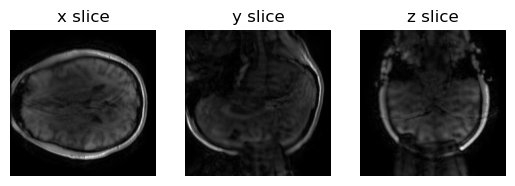

In [ ]:
# show the data
from vis3d import im
im(np.abs(x.squeeze(0).squeeze(0).cpu().detach().numpy()),viewtype='mid3')